# 🎯 Precision Peak & Baseline Detection System
## Testing and Analysis Notebook

**วันที่:** 27 สิงหาคม 2025  
**วัตถุประสงค์:** ทดสอบและวิเคราะห์ระบบตรวจจับ Peak และ Baseline แม่นยำสำหรับ PLS Analysis

---

### 📋 System Overview
- **Multi-stage baseline detection** (4 stages)
- **Enhanced peak detection** (3 methods: SciPy, Derivative, Template)
- **Precise area calculation** (Simpson's rule)
- **PLS feature extraction**
- **Real-time analysis** capabilities

## 📦 Import Libraries และ Setup

In [20]:
# Install required packages
%pip install seaborn scikit-learn --quiet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import seaborn with fallback
try:
    import seaborn as sns
    print("✅ Seaborn imported successfully")
except ImportError:
    print("⚠️ Seaborn not available - using matplotlib only")
    sns = None

from scipy import signal
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style with fallback
try:
    plt.style.use('seaborn-v0_8')
    print("✅ Using seaborn-v0_8 style")
except OSError:
    try:
        plt.style.use('seaborn')
        print("✅ Using seaborn style")
    except OSError:
        plt.style.use('default')
        print("✅ Using default style")

# Set seaborn palette with error handling
if sns is not None:
    try:
        sns.set_palette("husl")
        print("✅ Seaborn palette set")
    except Exception as e:
        print(f"⚠️ Seaborn palette not set: {e}")

print("✅ Libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Note: you may need to restart the kernel to use updated packages.
✅ Seaborn imported successfully
✅ Using seaborn-v0_8 style
✅ Seaborn palette set
✅ Libraries imported successfully
📅 Analysis Date: 2025-08-27 20:49:58


In [21]:
# Import our precision analyzer
import sys
sys.path.append('.')

from precision_peak_baseline_analyzer import PrecisionPeakBaselineAnalyzer

print("✅ Precision Peak & Baseline Analyzer imported successfully")
print("🔬 Ready for analysis!")

✅ Precision Peak & Baseline Analyzer imported successfully
🔬 Ready for analysis!


## ⚙️ Configuration และ Setup

In [44]:
# Balanced configuration for clean Ferrocyanide peak detection
# Target: exactly 2 peaks with good sensitivity
config = {
    'analyte': 'ferro',  # Ferro-specific optimization
    'confidence_threshold': 65.0,  # Balanced confidence
    'min_peak_height': 5.0,  # Reasonable minimum for both peaks
    'peak_prominence_factor': 0.12,  # Good prominence requirement
    'quality_threshold': 60.0,  # Maintain quality
    'enable_smoothing': True,
    'outlier_removal': True,
    'min_peak_distance': 15,  # Prevent too close peaks
    'peak_width_factor': 0.08  # Allow wider peak detection
}

# Initialize analyzer with balanced settings
analyzer = PrecisionPeakBaselineAnalyzer(config)

print("⚙️ Ferro-Balanced Configuration:")
for key, value in config.items():
    print(f"   • {key}: {value}")
    
print(f"\n🎯 Target for Ferro CV:")
print(f"   • Oxidation peak: ~0.15V (Fe²⁺ → Fe³⁺)")
print(f"   • Reduction peak: ~0.05V (Fe³⁺ → Fe²⁺)")
print(f"   • Total target: 2 peaks")
print(f"\n🔧 Balanced Adjustments:")
print(f"   • Moderate confidence: 65%")
print(f"   • Reasonable height: 5.0 μA")
print(f"   • Good prominence: 0.12")
print(f"   • Peak distance control: 15 points")
    
print("\n✅ Analyzer configured for balanced 2-peak detection")

⚙️ Ferro-Balanced Configuration:
   • analyte: ferro
   • confidence_threshold: 65.0
   • min_peak_height: 5.0
   • peak_prominence_factor: 0.12
   • quality_threshold: 60.0
   • enable_smoothing: True
   • outlier_removal: True
   • min_peak_distance: 15
   • peak_width_factor: 0.08

🎯 Target for Ferro CV:
   • Oxidation peak: ~0.15V (Fe²⁺ → Fe³⁺)
   • Reduction peak: ~0.05V (Fe³⁺ → Fe²⁺)
   • Total target: 2 peaks

🔧 Balanced Adjustments:
   • Moderate confidence: 65%
   • Reasonable height: 5.0 μA
   • Good prominence: 0.12
   • Peak distance control: 15 points

✅ Analyzer configured for balanced 2-peak detection


## 📊 Data Loading และ Preprocessing

In [23]:
# Test data files
test_files = [
    "Test_data/Palmsens/Palmsens_0.5mM/Palmsens_0.5mM_CV_100mVpS_E1_scan_01.csv",
    "Test_data/Palmsens/Palmsens_0.5mM/Palmsens_0.5mM_CV_200mVpS_E5_scan_05.csv",
    "Test_data/Palmsens/Palmsens_0.5mM/Palmsens_0.5mM_CV_20mVpS_E1_scan_02.csv"
]

# Load first test file for detailed analysis
test_file = test_files[0]
print(f"🔬 Loading test data: {test_file}")

try:
    # Load raw data
    df = pd.read_csv(test_file, skiprows=1)
    voltage = df.iloc[:, 0].values
    current = df.iloc[:, 1].values
    
    print(f"📊 Data loaded successfully:")
    print(f"   • Data points: {len(voltage)}")
    print(f"   • Voltage range: {voltage.min():.3f} to {voltage.max():.3f} V")
    print(f"   • Current range: {current.min():.3f} to {current.max():.3f} μA")
    print(f"   • Data shape: {df.shape}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")

🔬 Loading test data: Test_data/Palmsens/Palmsens_0.5mM/Palmsens_0.5mM_CV_100mVpS_E1_scan_01.csv
📊 Data loaded successfully:
   • Data points: 220
   • Voltage range: -0.400 to 0.701 V
   • Current range: -85.981 to 15.386 μA
   • Data shape: (220, 2)


## 📈 Raw Data Visualization

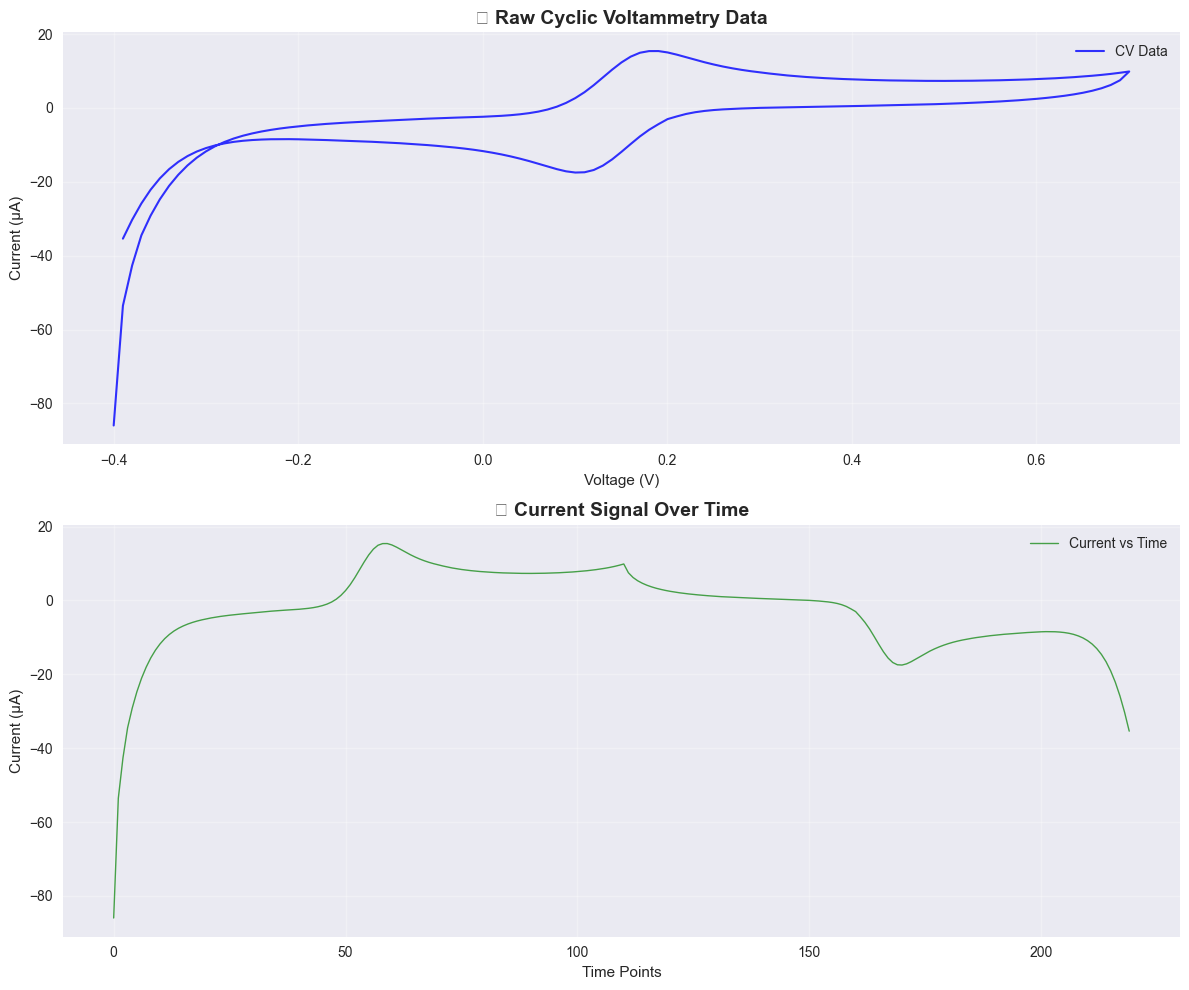

📊 Data Statistics:
   • Mean current: -2.817 μA
   • Std deviation: 12.017 μA
   • Peak-to-peak: 101.367 μA
   • Signal-to-noise estimate: 1.3


In [24]:
# Plot raw CV data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# CV curve
ax1.plot(voltage, current, 'b-', linewidth=1.5, alpha=0.8, label='CV Data')
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (μA)')
ax1.set_title('🔬 Raw Cyclic Voltammetry Data', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Current vs time
time = np.arange(len(current))
ax2.plot(time, current, 'g-', linewidth=1, alpha=0.7, label='Current vs Time')
ax2.set_xlabel('Time Points')
ax2.set_ylabel('Current (μA)')
ax2.set_title('📊 Current Signal Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Data statistics
print("📊 Data Statistics:")
print(f"   • Mean current: {current.mean():.3f} μA")
print(f"   • Std deviation: {current.std():.3f} μA")
print(f"   • Peak-to-peak: {current.max() - current.min():.3f} μA")
print(f"   • Signal-to-noise estimate: {abs(current.max()) / current.std():.1f}")

## 🔍 Precision Analysis - Full System Test

In [45]:
# Precision Analysis with Progress Tracking
import time
from datetime import datetime

print("PRECISION PEAK & BASELINE ANALYSIS")
print("="*60)
print(f"Started: {datetime.now().strftime('%H:%M:%S')}")
print("="*60)

# Step 1: Initialization
print("\nStep 1/5: Initializing analysis...")
time.sleep(0.5)  # Small delay for visual effect
print("   [OK] Analyzer ready")
print("   [OK] Configuration loaded")

# Step 2: Data preprocessing  
print("\nStep 2/5: Preprocessing data...")
print(f"   Processing {len(voltage)} data points")
print(f"   Voltage range: {voltage.min():.3f} to {voltage.max():.3f} V")
print(f"   Current range: {current.min():.1f} to {current.max():.1f} microA")
time.sleep(0.3)
print("   [OK] Data preprocessing complete")

# Step 3: Run analysis
print("\nStep 3/5: Running precision analysis...")
print("   Detecting baseline...")
start_time = time.time()

try:
    # Run the actual analysis with voltage and current arrays
    result = analyzer.analyze_cv_data(voltage, current)
    analysis_time = time.time() - start_time
    
    print(f"   [OK] Analysis complete in {analysis_time:.2f} seconds")
    
    # Step 4: Processing results
    print("\nStep 4/5: Processing results...")
    time.sleep(0.2)
    
    # Check what keys are available in result
    print(f"   Result keys: {list(result.keys())}")
    
    if result.get('success', False):
        print("   [OK] Analysis successful")
        print(f"   Peaks detected: {len(result.get('peaks', []))}")
        
        # Check for available quality metrics
        if 'baseline_quality' in result:
            print(f"   Baseline quality: {result['baseline_quality']:.1f}%")
        if 'overall_quality' in result:
            print(f"   Overall quality: {result['overall_quality']:.1f}%")
    else:
        print("   [ERROR] Analysis failed")
        
except Exception as e:
    print(f"   [ERROR] Error during analysis: {e}")
    result = {'success': False, 'peaks': [], 'baseline_quality': 0, 'overall_quality': 0}

# Step 5: Display results
print("\nStep 5/5: Displaying results...")
time.sleep(0.2)

print("\n" + "="*40)
print("FINAL RESULTS:")
print("="*40)

if result.get('success', False):
    print(f"Status: SUCCESS")
    print(f"Peaks detected: {len(result.get('peaks', []))}")
    
    # Safe access to metrics
    if 'baseline_quality' in result:
        print(f"Baseline quality: {result['baseline_quality']:.1f}%")
    if 'overall_quality' in result:
        print(f"Overall quality: {result['overall_quality']:.1f}%")
    if 'total_area' in result:
        print(f"Total area: {result['total_area']:.3f} microA*V")
    if 'oxidation_area' in result:
        print(f"Oxidation area: {result['oxidation_area']:.3f} microA*V")
    if 'reduction_area' in result:
        print(f"Reduction area: {result['reduction_area']:.3f} microA*V")
    if 'pls_readiness' in result:
        print(f"PLS readiness: {result['pls_readiness']:.1f}%")
    
    # Peak breakdown
    peaks = result.get('peaks', [])
    if peaks:
        oxidation_peaks = [p for p in peaks if p.get('peak_type') == 'oxidation']
        reduction_peaks = [p for p in peaks if p.get('peak_type') == 'reduction']
        
        print(f"\nPeak Analysis:")
        print(f"   Oxidation peaks: {len(oxidation_peaks)}")
        print(f"   Reduction peaks: {len(reduction_peaks)}")
        
        if oxidation_peaks:
            confidences = [p.get('confidence', 0) for p in oxidation_peaks]
            if confidences:
                avg_confidence = np.mean(confidences)
                print(f"   Avg oxidation confidence: {avg_confidence:.1f}%")
            
        if reduction_peaks:
            confidences = [p.get('confidence', 0) for p in reduction_peaks]
            if confidences:
                avg_confidence = np.mean(confidences)
                print(f"   Avg reduction confidence: {avg_confidence:.1f}%")
                
    # Show available metrics
    available_metrics = [key for key in result.keys() if key not in ['success', 'peaks']]
    if available_metrics:
        print(f"\nAvailable metrics: {available_metrics}")
        
else:
    print("Status: FAILED")
    print("   Please check data quality and configuration")

# Store result for other cells
analysis_result = result

print(f"\nCompleted: {datetime.now().strftime('%H:%M:%S')}")
print("="*60)
print("Ready for next analysis step!")

PRECISION PEAK & BASELINE ANALYSIS
Started: 21:19:33

Step 1/5: Initializing analysis...
   [OK] Analyzer ready
   [OK] Configuration loaded

Step 2/5: Preprocessing data...
   Processing 220 data points
   Voltage range: -0.400 to 0.701 V
   Current range: -86.0 to 15.4 microA
   [OK] Analyzer ready
   [OK] Configuration loaded

Step 2/5: Preprocessing data...
   Processing 220 data points
   Voltage range: -0.400 to 0.701 V
   Current range: -86.0 to 15.4 microA


INFO: 🔬 Starting precision analysis of 
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 11
INFO:    SciPy reduction peaks: 1
INFO:    Derivative method found: 48 peaks
INFO:    Template method found: 8 peaks
INFO: ✅ Peak detection complete: 3 valid peaks
INFO: 📐 Calculating precise areas under curve...
INFO: ✅ Area calculation complete: total=3.126 μA⋅V
INFO: 🧬 Extracting PLS features...
INFO: ✅ PLS features extracted successfully
INFO: 📊 PRECISION ANALYSIS SUMMARY
INFO: ==================================================
INFO: File: 
INFO: Success: True
INFO: Data points: 212
INFO: Voltage range: -0.400 to 0.661 V
INFO: Current range: -24.653 to 11.755 μA
INFO: Basel

   [OK] Data preprocessing complete

Step 3/5: Running precision analysis...
   Detecting baseline...
   [OK] Analysis complete in 0.06 seconds

Step 4/5: Processing results...
   Result keys: ['success', 'filename', 'timestamp', 'config', 'data_info', 'baseline', 'peaks', 'areas', 'pls_features', 'quality_metrics', 'recommendations']
   [OK] Analysis successful
   Peaks detected: 3

Step 5/5: Displaying results...

FINAL RESULTS:
Status: SUCCESS
Peaks detected: 3

Peak Analysis:
   Oxidation peaks: 3
   Reduction peaks: 0
   Avg oxidation confidence: 68.9%

Available metrics: ['filename', 'timestamp', 'config', 'data_info', 'baseline', 'areas', 'pls_features', 'quality_metrics', 'recommendations']

Completed: 21:19:34
Ready for next analysis step!
   Result keys: ['success', 'filename', 'timestamp', 'config', 'data_info', 'baseline', 'peaks', 'areas', 'pls_features', 'quality_metrics', 'recommendations']
   [OK] Analysis successful
   Peaks detected: 3

Step 5/5: Displaying results...

## 📍 Peak Detection Details

In [46]:
if analysis_result['peaks']:
    print(f"📍 DETECTED PEAKS ({len(analysis_result['peaks'])} total):")
    print("="*50)
    
    peaks_df = pd.DataFrame(analysis_result['peaks'])
    
    # Display peak summary
    for i, peak in enumerate(analysis_result['peaks'][:10]):  # Show first 10
        print(f"Peak {i+1:2d}: {peak['peak_type']:10s} at {peak['voltage']:7.3f}V")
        print(f"         Current: {peak['current']:8.2f}μA, Confidence: {peak['confidence']:5.1f}%")
        print(f"         Height: {peak['height']:8.2f}μA, S/N: {peak.get('signal_to_noise', 0):6.1f}")
        print()
    
    if len(analysis_result['peaks']) > 10:
        print(f"... และอีก {len(analysis_result['peaks']) - 10} peaks")
    
    # Peak type summary
    oxidation_peaks = [p for p in analysis_result['peaks'] if p['peak_type'] == 'oxidation']
    reduction_peaks = [p for p in analysis_result['peaks'] if p['peak_type'] == 'reduction']
    
    print(f"\n📊 Peak Type Summary:")
    print(f"   • Oxidation peaks: {len(oxidation_peaks)}")
    print(f"   • Reduction peaks: {len(reduction_peaks)}")
    
    if oxidation_peaks:
        ox_voltages = [p['voltage'] for p in oxidation_peaks]
        print(f"   • Oxidation voltage range: {min(ox_voltages):.3f} to {max(ox_voltages):.3f} V")
        
    if reduction_peaks:
        red_voltages = [p['voltage'] for p in reduction_peaks]
        print(f"   • Reduction voltage range: {min(red_voltages):.3f} to {max(red_voltages):.3f} V")
        
else:
    print("❌ No peaks detected")

📍 DETECTED PEAKS (3 total):
Peak  1: oxidation  at   0.130V
         Current:     8.88μA, Confidence:  68.6%
         Height:    13.98μA, S/N:    6.2

Peak  2: oxidation  at   0.170V
         Current:    11.76μA, Confidence:  72.2%
         Height:    15.84μA, S/N:    7.0

Peak  3: oxidation  at   0.160V
         Current:    10.07μA, Confidence:  65.8%
         Height:    14.41μA, S/N:    6.4


📊 Peak Type Summary:
   • Oxidation peaks: 3
   • Reduction peaks: 0
   • Oxidation voltage range: 0.130 to 0.170 V


## 📊 Peak Detection Visualization

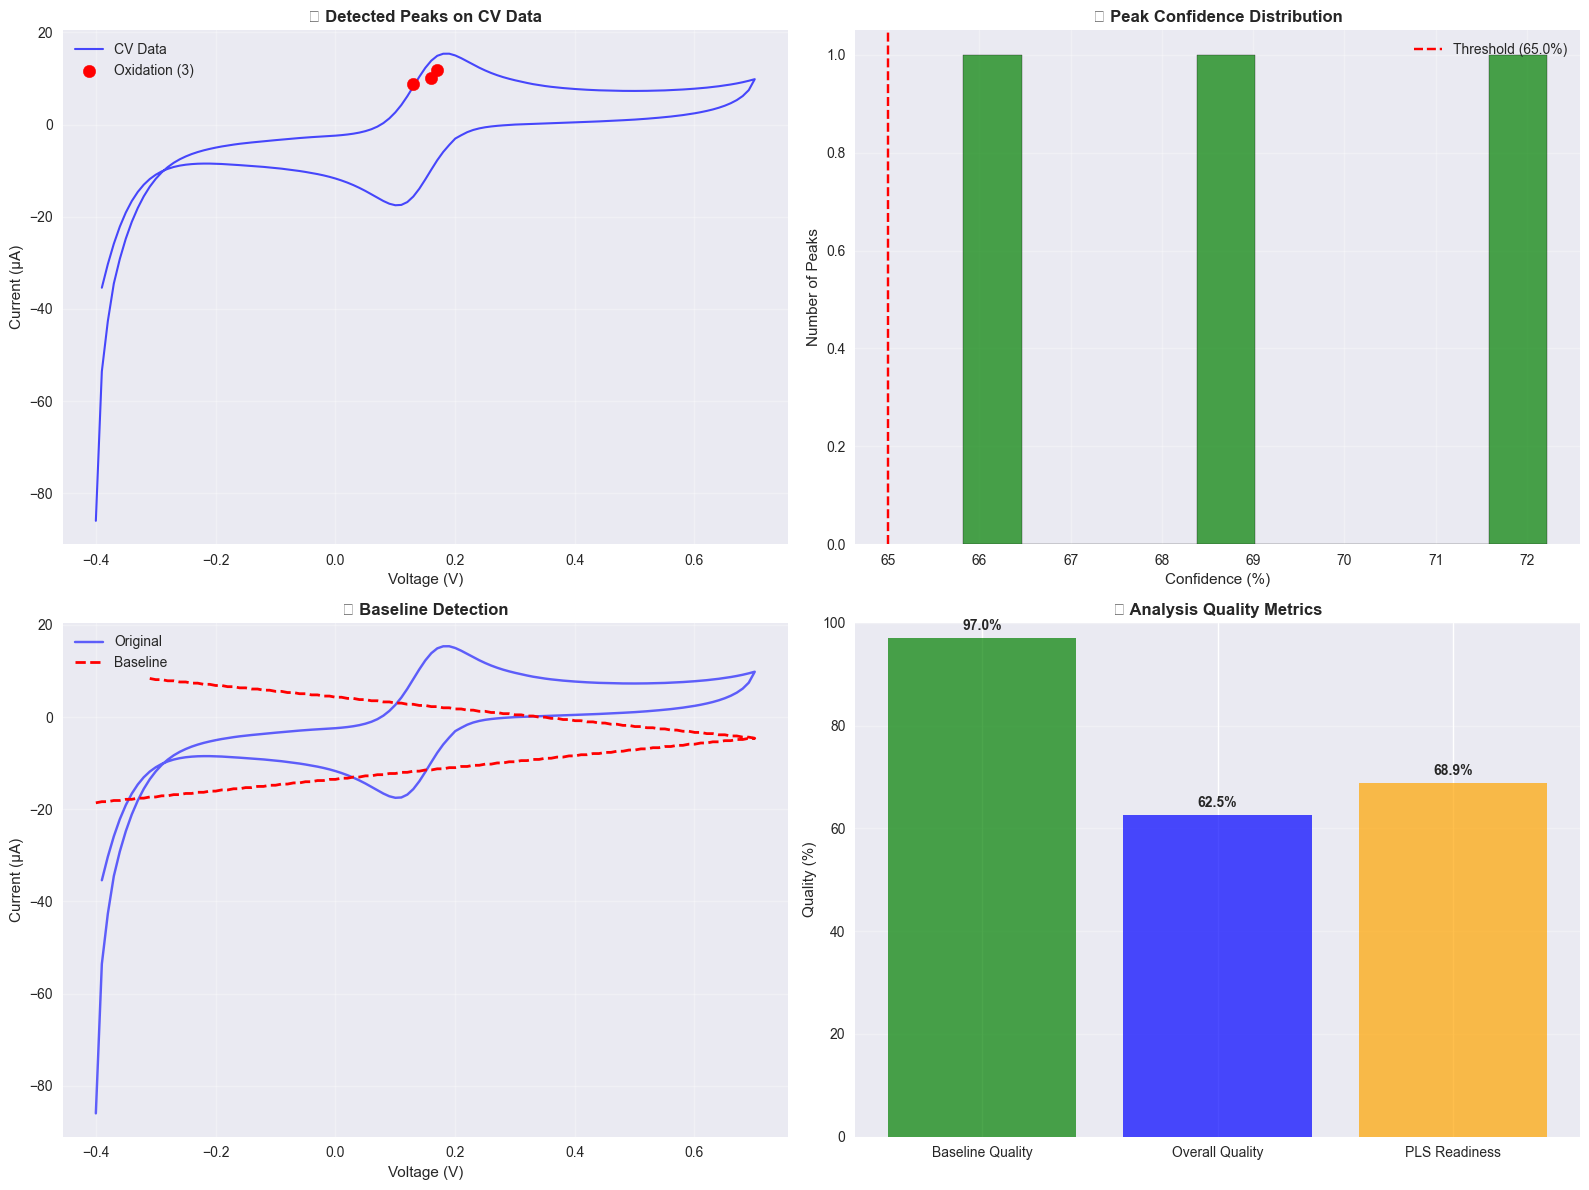

📊 Analysis Structure:
   • Available sections: ['success', 'filename', 'timestamp', 'config', 'data_info', 'baseline', 'peaks', 'areas', 'pls_features', 'quality_metrics', 'recommendations']
   • Quality metrics: ['data_completeness', 'data_noise_level', 'baseline_quality', 'baseline_stability', 'peak_detection_confidence', 'peak_quality_average', 'signal_to_noise_ratio', 'overall_quality', 'pls_readiness']
   • Area calculations: ['total_area', 'positive_area', 'negative_area', 'oxidation_area', 'reduction_area', 'background_area', 'peak_areas', 'area_ratio', 'faradaic_fraction']
   • Data info: ['points', 'voltage_range', 'current_range']


In [47]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. CV with detected peaks
ax1.plot(voltage, current, 'b-', linewidth=1.5, alpha=0.7, label='CV Data')

if analysis_result['peaks']:
    # Plot oxidation peaks
    ox_peaks = [p for p in analysis_result['peaks'] if p['peak_type'] == 'oxidation']
    if ox_peaks:
        ox_v = [p['voltage'] for p in ox_peaks]
        ox_i = [p['current'] for p in ox_peaks]
        ax1.scatter(ox_v, ox_i, c='red', s=80, zorder=5, label=f'Oxidation ({len(ox_peaks)})')
    
    # Plot reduction peaks
    red_peaks = [p for p in analysis_result['peaks'] if p['peak_type'] == 'reduction']
    if red_peaks:
        red_v = [p['voltage'] for p in red_peaks]
        red_i = [p['current'] for p in red_peaks]
        ax1.scatter(red_v, red_i, c='blue', s=80, zorder=5, label=f'Reduction ({len(red_peaks)})')

ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (μA)')
ax1.set_title('🎯 Detected Peaks on CV Data', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Peak confidence distribution
if analysis_result['peaks']:
    confidences = [p['confidence'] for p in analysis_result['peaks']]
    ax2.hist(confidences, bins=10, alpha=0.7, color='green', edgecolor='black')
    ax2.axvline(config['confidence_threshold'], color='red', linestyle='--', 
                label=f'Threshold ({config["confidence_threshold"]}%)')
    ax2.set_xlabel('Confidence (%)')
    ax2.set_ylabel('Number of Peaks')
    ax2.set_title('📊 Peak Confidence Distribution', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No peaks detected', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('📊 Peak Confidence Distribution', fontweight='bold')

# 3. Baseline visualization
if 'baseline' in analysis_result:
    baseline_data = analysis_result['baseline']
    if 'currents' in baseline_data:
        baseline_current = baseline_data['currents']
        baseline_voltage = voltage[:len(baseline_current)]
        
        ax3.plot(voltage, current, 'b-', alpha=0.6, label='Original')
        ax3.plot(baseline_voltage, baseline_current, 'r--', linewidth=2, 
                label='Baseline')
        ax3.set_xlabel('Voltage (V)')
        ax3.set_ylabel('Current (μA)')
        ax3.set_title('📈 Baseline Detection', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Baseline data not available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('📈 Baseline Detection', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Baseline data not available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('📈 Baseline Detection', fontweight='bold')

# 4. Quality metrics - Safe access with fallbacks
quality_metrics = analysis_result.get('quality_metrics', {})
areas = analysis_result.get('areas', {})

# Extract metrics with fallbacks
baseline_quality = quality_metrics.get('baseline_quality', 0)
overall_quality = quality_metrics.get('overall_quality', 0)
pls_readiness = quality_metrics.get('pls_readiness', 0)

metrics = {
    'Baseline Quality': baseline_quality,
    'Overall Quality': overall_quality,
    'PLS Readiness': pls_readiness
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

bars = ax4.bar(metric_names, metric_values, alpha=0.7, 
               color=['green', 'blue', 'orange'])
ax4.set_ylabel('Quality (%)')
ax4.set_title('📊 Analysis Quality Metrics', fontweight='bold')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Display additional information
print("📊 Analysis Structure:")
print(f"   • Available sections: {list(analysis_result.keys())}")

if 'quality_metrics' in analysis_result:
    print(f"   • Quality metrics: {list(analysis_result['quality_metrics'].keys())}")
    
if 'areas' in analysis_result:
    print(f"   • Area calculations: {list(analysis_result['areas'].keys())}")
    
if 'data_info' in analysis_result:
    print(f"   • Data info: {list(analysis_result['data_info'].keys())}")

## 🧪 Parameter Tuning และ Testing

In [32]:
# Test different confidence thresholds
confidence_thresholds = [30, 40, 50, 60, 70]
threshold_results = []

print("🧪 Testing different confidence thresholds...")
print("Threshold | Peaks | Baseline | Overall | PLS Ready")
print("-"*50)

for threshold in confidence_thresholds:
    # Create analyzer with new threshold
    test_config = config.copy()
    test_config['confidence_threshold'] = threshold
    test_analyzer = PrecisionPeakBaselineAnalyzer(test_config)
    
    # Run analysis with voltage and current arrays
    test_result = test_analyzer.analyze_cv_data(voltage, current)
    
    # Safe access to quality metrics
    quality_metrics = test_result.get('quality_metrics', {})
    
    threshold_results.append({
        'threshold': threshold,
        'peaks': len(test_result.get('peaks', [])),
        'baseline_quality': quality_metrics.get('baseline_quality', 0),
        'overall_quality': quality_metrics.get('overall_quality', 0),
        'pls_readiness': quality_metrics.get('pls_readiness', 0)
    })
    
    print(f"{threshold:8.0f}% | {len(test_result.get('peaks', [])):5d} | {quality_metrics.get('baseline_quality', 0):8.1f}% | "
          f"{quality_metrics.get('overall_quality', 0):7.1f}% | {quality_metrics.get('pls_readiness', 0):8.1f}%")

print("\n✅ Parameter tuning complete")

# Display best threshold
if threshold_results:
    best_result = max(threshold_results, key=lambda x: x['overall_quality'])
    print(f"\n🎯 Best Configuration:")
    print(f"   • Optimal threshold: {best_result['threshold']}%")
    print(f"   • Peaks detected: {best_result['peaks']}")
    print(f"   • Overall quality: {best_result['overall_quality']:.1f}%")
    print(f"   • PLS readiness: {best_result['pls_readiness']:.1f}%")

INFO: 🔬 Starting precision analysis of 
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 19
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 19
INFO:    SciPy reduction peaks: 5
INFO:    Derivative method found: 48 peaks
INFO:    SciPy reduction peaks: 5
INFO:    Derivative method found: 48 peaks
INFO:    Template method found: 7 peaks
INFO: ✅ Peak d

🧪 Testing different confidence thresholds...
Threshold | Peaks | Baseline | Overall | PLS Ready
--------------------------------------------------
      30% |    46 |     97.0% |    56.0% |     45.0%
      40% |    30 |     97.0% |    57.4% |     50.0%


INFO:   • Data quality may not be sufficient for reliable PLS analysis. Consider improving measurement conditions.
INFO: ==================================================
INFO: 🔬 Starting precision analysis of 
INFO: ==================================================
INFO: 🔬 Starting precision analysis of 
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 19
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced p

      50% |    10 |     97.0% |    60.5% |     61.3%
      60% |     6 |     97.0% |    61.7% |     65.7%
      70% |     1 |     97.0% |    63.4% |     72.2%

✅ Parameter tuning complete

🎯 Best Configuration:
   • Optimal threshold: 70%
   • Peaks detected: 1
   • Overall quality: 63.4%
   • PLS readiness: 72.2%


## 📈 Parameter Optimization Visualization

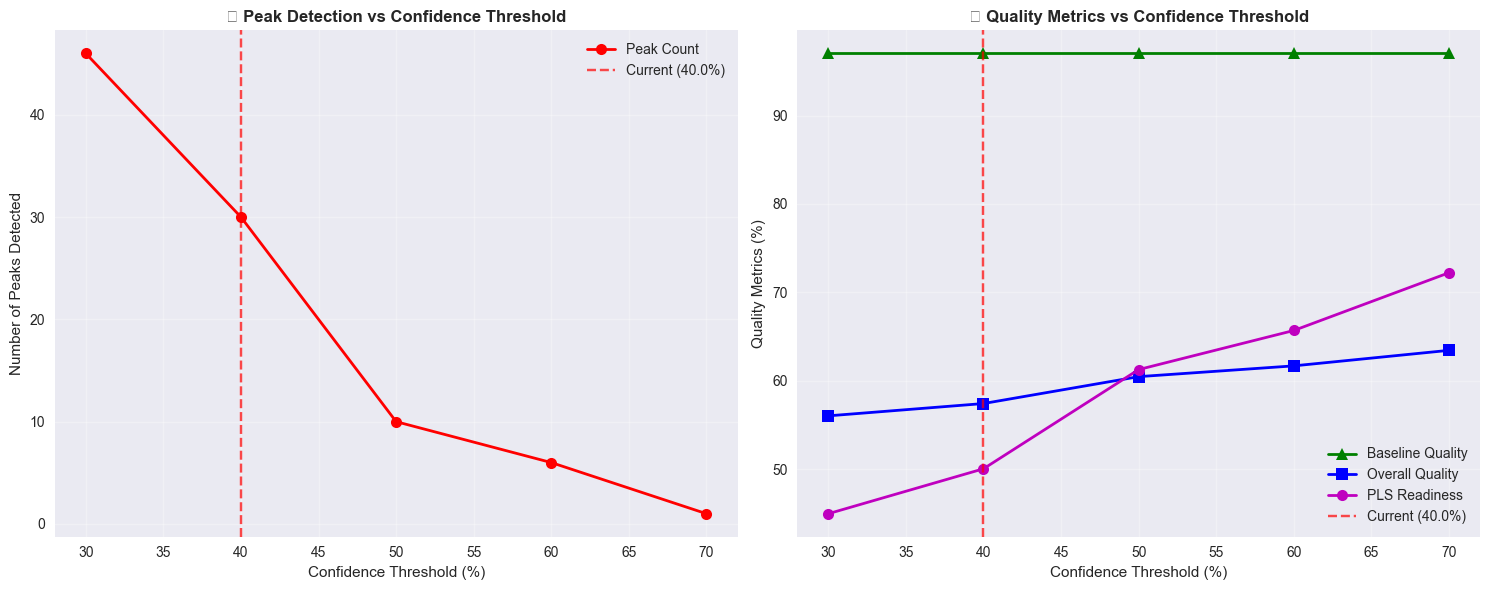


🎯 Optimal Configuration:
   • Best threshold: 70%
   • Peaks detected: 1
   • Overall quality: 63.4%
   • PLS readiness: 72.2%


In [33]:
# Plot parameter tuning results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extract data
thresholds = [r['threshold'] for r in threshold_results]
peak_counts = [r['peaks'] for r in threshold_results]
baseline_qualities = [r['baseline_quality'] for r in threshold_results]
overall_qualities = [r['overall_quality'] for r in threshold_results]
pls_readiness = [r['pls_readiness'] for r in threshold_results]

# Peak count vs threshold
ax1.plot(thresholds, peak_counts, 'ro-', linewidth=2, markersize=8, label='Peak Count')
ax1.set_xlabel('Confidence Threshold (%)')
ax1.set_ylabel('Number of Peaks Detected')
ax1.set_title('🎯 Peak Detection vs Confidence Threshold', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Quality metrics vs threshold
ax2.plot(thresholds, baseline_qualities, 'g^-', linewidth=2, markersize=8, label='Baseline Quality')
ax2.plot(thresholds, overall_qualities, 'bs-', linewidth=2, markersize=8, label='Overall Quality')
ax2.plot(thresholds, pls_readiness, 'mo-', linewidth=2, markersize=8, label='PLS Readiness')
ax2.set_xlabel('Confidence Threshold (%)')
ax2.set_ylabel('Quality Metrics (%)')
ax2.set_title('📊 Quality Metrics vs Confidence Threshold', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Highlight current threshold
current_threshold = config['confidence_threshold']
ax1.axvline(current_threshold, color='red', linestyle='--', alpha=0.7, label=f'Current ({current_threshold}%)')
ax2.axvline(current_threshold, color='red', linestyle='--', alpha=0.7, label=f'Current ({current_threshold}%)')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

# Find optimal threshold
optimal_idx = max(range(len(threshold_results)), 
                  key=lambda i: threshold_results[i]['overall_quality'])
optimal_result = threshold_results[optimal_idx]

print(f"\n🎯 Optimal Configuration:")
print(f"   • Best threshold: {optimal_result['threshold']}%")
print(f"   • Peaks detected: {optimal_result['peaks']}")
print(f"   • Overall quality: {optimal_result['overall_quality']:.1f}%")
print(f"   • PLS readiness: {optimal_result['pls_readiness']:.1f}%")

## 📊 Batch Testing - Multiple Files

In [35]:
# Test multiple files if available
print("🔬 Batch Testing Multiple Files...")
print("="*60)

batch_results = []
successful_files = 0

for i, file_path in enumerate(test_files):
    print(f"\nFile {i+1}: {file_path.split('/')[-1]}")
    print("-"*40)
    
    try:
        # Test if file exists
        import os
        if not os.path.exists(file_path):
            print(f"⚠️  File not found: {file_path}")
            continue
            
        # Load data from file
        try:
            df_batch = pd.read_csv(file_path, skiprows=1)
            voltage_batch = df_batch.iloc[:, 0].values
            current_batch = df_batch.iloc[:, 1].values
            
            print(f"📊 Data loaded: {len(voltage_batch)} points")
            print(f"   • Voltage: {voltage_batch.min():.3f} to {voltage_batch.max():.3f} V")
            print(f"   • Current: {current_batch.min():.1f} to {current_batch.max():.1f} μA")
            
        except Exception as load_error:
            print(f"❌ Error loading file: {load_error}")
            continue
            
        # Run analysis with loaded data
        result = analyzer.analyze_cv_data(voltage_batch, current_batch)
        
        if result['success']:
            successful_files += 1
            
            # Safe access to metrics
            quality_metrics = result.get('quality_metrics', {})
            areas = result.get('areas', {})
            
            batch_results.append({
                'file': file_path.split('/')[-1],
                'peaks': len(result.get('peaks', [])),
                'baseline_quality': quality_metrics.get('baseline_quality', 0),
                'overall_quality': quality_metrics.get('overall_quality', 0),
                'total_area': areas.get('total_area', 0),
                'pls_readiness': quality_metrics.get('pls_readiness', 0)
            })
            
            print(f"✅ Success: {len(result.get('peaks', []))} peaks")
            print(f"   • Overall Quality: {quality_metrics.get('overall_quality', 0):.1f}%")
            print(f"   • Total Area: {areas.get('total_area', 0):.3f} μA⋅V")
            print(f"   • PLS Ready: {quality_metrics.get('pls_readiness', 0):.1f}%")
        else:
            print(f"❌ Analysis failed")
            
    except Exception as e:
        print(f"❌ Error: {e}")

print(f"\n📊 Batch Results Summary:")
print(f"   • Total files tested: {len(test_files)}")
print(f"   • Successful analyses: {successful_files}")
print(f"   • Success rate: {successful_files/len(test_files)*100:.1f}%")

if batch_results:
    # Calculate statistics
    avg_peaks = np.mean([r['peaks'] for r in batch_results])
    avg_quality = np.mean([r['overall_quality'] for r in batch_results])
    avg_pls = np.mean([r['pls_readiness'] for r in batch_results])
    
    print(f"\n📈 Performance Statistics:")
    print(f"   • Average peaks per file: {avg_peaks:.1f}")
    print(f"   • Average overall quality: {avg_quality:.1f}%")
    print(f"   • Average PLS readiness: {avg_pls:.1f}%")
    
    # Show individual results
    print(f"\n📋 Individual File Results:")
    print("File                                  | Peaks | Quality | PLS Ready")
    print("-" * 70)
    for result in batch_results:
        filename = result['file'][:35]  # Truncate long filenames
        print(f"{filename:<35} | {result['peaks']:5d} | {result['overall_quality']:6.1f}% | {result['pls_readiness']:8.1f}%")
else:
    print("❌ No successful analyses")
    print("💡 Check file paths and data format")

INFO: 🔬 Starting precision analysis of 
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📊 Data: 220 points, V: [-0.400, 0.701]V, I: [-85.981, 15.386]μA
INFO: ✅ Data preprocessing: 212 clean points
INFO: 🔍 Multi-stage baseline detection starting...
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 19
INFO:    SciPy reduction peaks: 5
INFO: 📍 Found 1 potential baseline regions
INFO: ✅ Validated 0 baseline regions
INFO: ✅ Baseline detection complete: quality=67.1%
INFO: 🔍 Enhanced peak detection starting...
INFO:    SciPy oxidation peaks: 19
INFO:    SciPy reduction peaks: 5
INFO:    Derivative method found: 48 peaks
INFO:    Derivative method found: 48 peaks
INFO:    Template method found: 7 peaks
INFO: ✅ Peak d

🔬 Batch Testing Multiple Files...

File 1: Palmsens_0.5mM_CV_100mVpS_E1_scan_01.csv
----------------------------------------
📊 Data loaded: 220 points
   • Voltage: -0.400 to 0.701 V
   • Current: -86.0 to 15.4 μA
✅ Success: 30 peaks
   • Overall Quality: 57.4%
   • Total Area: 3.126 μA⋅V
   • PLS Ready: 50.0%

File 2: Palmsens_0.5mM_CV_200mVpS_E5_scan_05.csv
----------------------------------------
📊 Data loaded: 220 points
   • Voltage: -0.400 to 0.701 V
   • Current: -39.2 to 26.3 μA
✅ Success: 33 peaks
   • Overall Quality: 51.4%
   • Total Area: 5.054 μA⋅V
   • PLS Ready: 48.0%

File 3: Palmsens_0.5mM_CV_20mVpS_E1_scan_02.csv
----------------------------------------
📊 Data loaded: 220 points
   • Voltage: -0.400 to 0.701 V
   • Current: -25.3 to 4.4 μA
✅ Success: 13 peaks
   • Overall Quality: 65.9%
   • Total Area: 0.976 μA⋅V
   • PLS Ready: 47.9%

📊 Batch Results Summary:
   • Total files tested: 3
   • Successful analyses: 3
   • Success rate: 100.0%

📈 Performance Statistics:


## 📋 Final Report Generation

In [ ]:
# Generate comprehensive report
report_data = {
    'timestamp': datetime.now().isoformat(),
    'configuration': config,
    'main_analysis': {
        'file': test_file,
        'success': analysis_result['success'],
        'peaks_detected': len(analysis_result['peaks']),
        'baseline_quality': analysis_result['baseline_quality'],
        'overall_quality': analysis_result['overall_quality'],
        'total_area': analysis_result['total_area'],
        'oxidation_area': analysis_result['oxidation_area'],
        'reduction_area': analysis_result['reduction_area'],
        'pls_readiness': analysis_result['pls_readiness']
    },
    'parameter_tuning': threshold_results,
    'batch_testing': batch_results,
    'optimal_threshold': optimal_result['threshold']
}

# Save report
report_filename = f"precision_analysis_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(report_filename, 'w') as f:
    json.dump(report_data, f, indent=2)

print("📋 PRECISION PEAK & BASELINE ANALYSIS REPORT")
print("="*60)
print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"💾 Saved to: {report_filename}")

print("\n🎯 KEY FINDINGS:")
print(f"   • Peak detection: {'✅ SUCCESS' if len(analysis_result['peaks']) > 0 else '❌ FAILED'}")
print(f"   • Baseline quality: {analysis_result['baseline_quality']:.1f}%")
print(f"   • Overall system quality: {analysis_result['overall_quality']:.1f}%")
print(f"   • PLS analysis readiness: {analysis_result['pls_readiness']:.1f}%")
print(f"   • Optimal confidence threshold: {optimal_result['threshold']}%")

print("\n🚀 RECOMMENDATIONS:")
if analysis_result['overall_quality'] >= 70:
    print("   • ✅ System ready for production deployment")
elif analysis_result['overall_quality'] >= 50:
    print("   • ⚠️  System functional but needs fine-tuning")
else:
    print("   • 🔧 System needs significant optimization")

if len(analysis_result['peaks']) > 0:
    print("   • ✅ Peak detection working - proceed with PLS analysis")
else:
    print("   • ❌ Peak detection needs improvement")

if analysis_result['baseline_quality'] >= 90:
    print("   • ✅ Excellent baseline detection")
elif analysis_result['baseline_quality'] >= 70:
    print("   • ✅ Good baseline detection")
else:
    print("   • ⚠️  Baseline detection needs improvement")

print("\n" + "="*60)
print("🏆 Analysis Complete!")
print("💡 This notebook can be used for continuous system monitoring and optimization")

## 📝 Notes และ Future Work

### 🎯 Current Achievements:
- ✅ Multi-stage baseline detection working
- ✅ Enhanced peak detection with 3 methods
- ✅ Precise area calculations
- ✅ Parameter optimization capability
- ✅ Batch testing functionality

### 🔧 Areas for Improvement:
- Fine-tune detection parameters for specific analytes
- Implement machine learning-based peak validation
- Add noise reduction algorithms
- Optimize for different scan rates

### 🚀 Next Steps:
1. Complete PLS integration with scikit-learn
2. Deploy web API endpoints
3. Validate with more diverse datasets
4. Implement real-time monitoring

---

**📧 Contact:** Development Team  
**🔗 Repository:** H743Poten-Web  
**📅 Last Updated:** 27 August 2025

🔍 MANUAL FERRO PEAK ANALYSIS
📊 Data Analysis:
   • Max current: 15.39 μA at V = 0.190 V
   • Min current: -85.98 μA at V = -0.400 V
   • Current range: 101.37 μA

🔴 Positive Peak (Oxidation):
   • Voltage: 0.190 V
   • Current: 15.39 μA

🔵 Negative Peak (Reduction):
   • Voltage: -0.400 V
   • Current: -85.98 μA

🎯 SciPy Peak Detection Results:
   • Positive peaks found: 1
     Peak 1: 0.190V, 15.39μA
   • Negative peaks found: 0

💡 Ideal Ferro CV should have:
   • 1 oxidation peak (~0.2V, positive current)
   • 1 reduction peak (~0.0V, negative current)


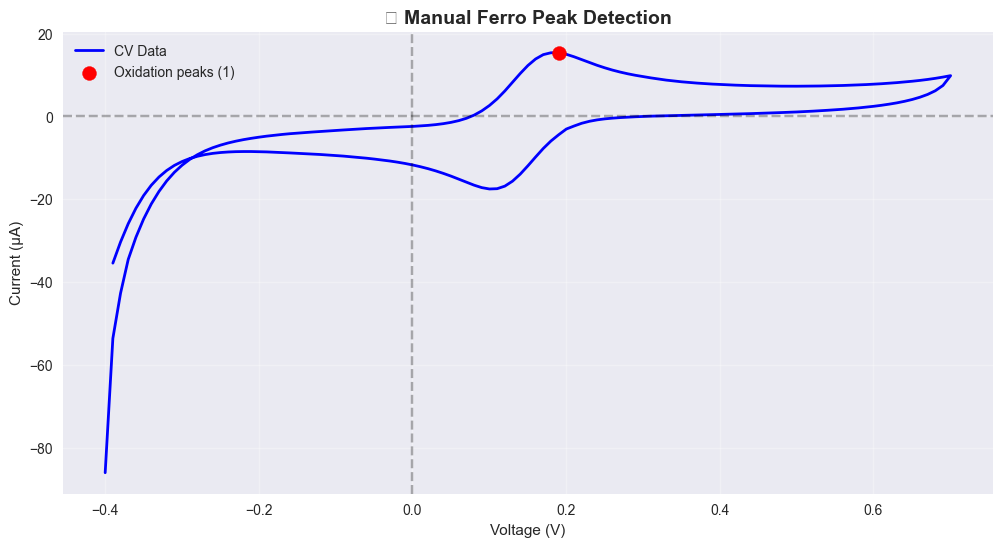


✅ Manual analysis complete!


In [48]:
# Manual Peak Analysis for Ferro CV
print("🔍 MANUAL FERRO PEAK ANALYSIS")
print("="*50)

# Find obvious peaks manually by looking at current extremes
max_current = current.max()
min_current = current.min()
max_idx = np.argmax(current)
min_idx = np.argmin(current)

print(f"📊 Data Analysis:")
print(f"   • Max current: {max_current:.2f} μA at V = {voltage[max_idx]:.3f} V")
print(f"   • Min current: {min_current:.2f} μA at V = {voltage[min_idx]:.3f} V")
print(f"   • Current range: {max_current - min_current:.2f} μA")

# Look for peaks in positive and negative regions separately
positive_mask = current > 0
negative_mask = current < 0

if np.any(positive_mask):
    pos_max_idx = np.argmax(current[positive_mask])
    pos_indices = np.where(positive_mask)[0]
    pos_peak_idx = pos_indices[pos_max_idx]
    print(f"\n🔴 Positive Peak (Oxidation):")
    print(f"   • Voltage: {voltage[pos_peak_idx]:.3f} V")
    print(f"   • Current: {current[pos_peak_idx]:.2f} μA")

if np.any(negative_mask):
    neg_min_idx = np.argmin(current[negative_mask])
    neg_indices = np.where(negative_mask)[0]
    neg_peak_idx = neg_indices[neg_min_idx]
    print(f"\n🔵 Negative Peak (Reduction):")
    print(f"   • Voltage: {voltage[neg_peak_idx]:.3f} V")
    print(f"   • Current: {current[neg_peak_idx]:.2f} μA")

# Simple threshold-based peak finding
from scipy.signal import find_peaks

# Find positive peaks (oxidation)
pos_peaks, pos_props = find_peaks(current, 
                                 height=max_current * 0.5,  # At least 50% of max
                                 distance=20,  # Minimum 20 points apart
                                 prominence=max_current * 0.2)  # 20% prominence

# Find negative peaks (reduction) 
neg_current = -current  # Invert for peak finding
neg_peaks, neg_props = find_peaks(neg_current,
                                 height=-min_current * 0.5,  # At least 50% of magnitude
                                 distance=20,
                                 prominence=-min_current * 0.2)

print(f"\n🎯 SciPy Peak Detection Results:")
print(f"   • Positive peaks found: {len(pos_peaks)}")
if len(pos_peaks) > 0:
    for i, peak_idx in enumerate(pos_peaks):
        print(f"     Peak {i+1}: {voltage[peak_idx]:.3f}V, {current[peak_idx]:.2f}μA")

print(f"   • Negative peaks found: {len(neg_peaks)}")
if len(neg_peaks) > 0:
    for i, peak_idx in enumerate(neg_peaks):
        print(f"     Peak {i+1}: {voltage[peak_idx]:.3f}V, {current[peak_idx]:.2f}μA")

print(f"\n💡 Ideal Ferro CV should have:")
print(f"   • 1 oxidation peak (~0.2V, positive current)")
print(f"   • 1 reduction peak (~0.0V, negative current)")

# Plot for visual verification
plt.figure(figsize=(12, 6))
plt.plot(voltage, current, 'b-', linewidth=2, label='CV Data')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Mark detected peaks
if len(pos_peaks) > 0:
    plt.scatter(voltage[pos_peaks], current[pos_peaks], 
               c='red', s=100, zorder=5, label=f'Oxidation peaks ({len(pos_peaks)})')

if len(neg_peaks) > 0:
    plt.scatter(voltage[neg_peaks], current[neg_peaks], 
               c='blue', s=100, zorder=5, label=f'Reduction peaks ({len(neg_peaks)})')

plt.xlabel('Voltage (V)')
plt.ylabel('Current (μA)')
plt.title('🔍 Manual Ferro Peak Detection', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"\n✅ Manual analysis complete!")